## Импорт библиотек

In [22]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
from matplotlib import pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

## Вариант 1

**Цель:** Контроль дисперсии весов.

- Разработайте архитектуру, которая будет за **5 слоев** приводить тензор к размерности `(1, 512, 1, 1)`.
- **Условие:** дисперсия весов третьего слоя должна быть в **два раза больше**, чем у второго и четвертого.
- **Эксперимент:** Проверьте влияние увеличенной дисперсии третьего слоя на распределение активаций после GAP и визуализируйте их гистограмму.

In [23]:
# Модель с контролем дисперсий

class NetV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1, bias=False)
        self.conv5 = nn.Conv2d(512, 512, 1, bias=False)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.relu = nn.ReLU()

        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.conv3.weight, mean=0.0, std=0.04) # больше, чем у 2 и 4
        nn.init.normal_(self.conv4.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.conv5.weight, mean=0.0, std=0.01)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        x_gap = self.gap(x)

        return x_gap

In [ ]:
# Базовая модель (дисперсия везде одинаковая)

class NetBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1, bias=False)
        self.conv5 = nn.Conv2d(512, 512, 1, bias=False)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.relu = nn.ReLU()

        for m in [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]:
            nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        x_gap = self.gap(x)

        return x_gap

In [ ]:
model_v1 = NetV1()
model_base = NetBase()

out_v1 = model_v1(x)
out_base = model_base(x)

print(out_v1.shape)
print(out_base.shape)

torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])


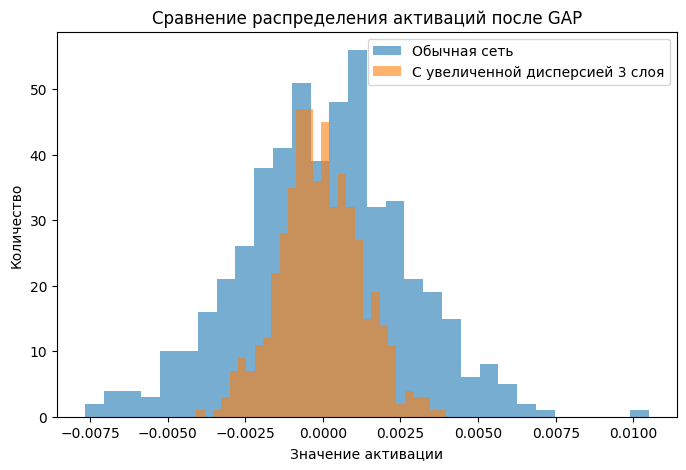

In [27]:
plt.hist(out_base.detach().numpy().flatten(), bins=30, alpha=0.6, label='Обычная сеть')
plt.hist(out_v1.detach().numpy().flatten(), bins=30, alpha=0.6, label='С увеличенной дисперсией 3 слоя')
plt.legend()
plt.title("Сравнение распределения активаций после GAP")
plt.xlabel("Значение активации")
plt.ylabel("Количество")
plt.show()

**Выводы**:


1.   При увеличении дисперсии весов третьего слоя распределение активаций после GAP стало более узким
2.   Больший разброс весов приводит к более сильным колебаниям значений на промежуточных слоях, и значительная часть этих значений обнуляется функцией активации ReLU, что в итоге сужает распределение финальных активаций


## Вариант 4. Сравнение GAP и Flatten

**Цель:** Понимание различий между Flatten и Global Average Pooling.

- Спроектируйте сеть с 3 свёрточными слоями, после которых выходной тензор `(batch, 128, 8, 8)`.
- **Условие:** Реализуйте два варианта классификации:
  1. `Flatten → Linear`
  2. `Global Average Pooling → Linear`
- **Эксперимент:** Обучите оба варианта на данных и сравните дисперсию выходных активаций перед финальным слоем.

In [33]:
class ConvNetFlatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc = nn.Linear(128*8*8, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        pre_fc = x
        x = self.fc(pre_fc)
        return x, pre_fc


class ConvNetGAP(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d((1,1))  # GAP
        self.fc = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        pre_fc = x
        x = self.fc(pre_fc)
        return x, pre_fc

In [34]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_flatten = ConvNetFlatten().to(device)
model_gap = ConvNetGAP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_flat = Adam(model_flatten.parameters(), lr=0.001)
optimizer_gap = Adam(model_gap.parameters(), lr=0.001)

epochs = 5

def train_one_epoch(model, optimizer, loader):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# дисперсия перед финальным слоем
def evaluate_variance(model, loader):
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            _, pre_fc = model(images)
            var = pre_fc.var(dim=0).mean().item()
            return var

for epoch in range(epochs):
    loss_flat = train_one_epoch(model_flatten, optimizer_flat, train_loader)
    loss_gap = train_one_epoch(model_gap, optimizer_gap, train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Flatten Loss: {loss_flat:.4f} | GAP Loss: {loss_gap:.4f}")

var_flat = evaluate_variance(model_flatten, test_loader)
var_gap = evaluate_variance(model_gap, test_loader)


100%|██████████| 782/782 [02:00<00:00,  6.47it/s]


Epoch 1/5 - Flatten Loss: 1.4578 | GAP Loss: 1.8427


100%|██████████| 782/782 [01:58<00:00,  6.58it/s]


Epoch 2/5 - Flatten Loss: 1.0675 | GAP Loss: 1.5650


100%|██████████| 782/782 [01:54<00:00,  6.83it/s]


Epoch 3/5 - Flatten Loss: 0.8934 | GAP Loss: 1.4480


100%|██████████| 782/782 [01:54<00:00,  6.84it/s]


Epoch 4/5 - Flatten Loss: 0.7825 | GAP Loss: 1.3597


100%|██████████| 782/782 [01:53<00:00,  6.90it/s]


Epoch 5/5 - Flatten Loss: 0.7047 | GAP Loss: 1.2938
Flatten pre_fc variance: 0.016554435715079308
GAP pre_fc variance: 0.28037962317466736


In [37]:
print(f"Flatten var: {var_flat}")
print(f"GAP var: {var_gap}")

Flatten var: 0.016554435715079308
GAP var: 0.28037962317466736


**Выводы**:


1.   Модель с Flatten демонстрирует более высокую точность уже с первой эпохи.
Это может быть связано с тем, что Flatten даёт большое количество признаков, однако их активации обладают низкой дисперсией из-за усреднения информации по множеству элементов
2.   У Global Average Pooling число признаков меньше, но каждый из них имеет более высокую активацию и большую значимость. GAP агрегирует пространственную информацию по всему изображению.